In [1]:
!pip install stable-baselines3
import gymnasium as gym
from gymnasium import error as gym_error
from stable_baselines3 import DQN
from stable_baselines3.common.atari_wrappers import AtariWrapper
import numpy as np
import matplotlib.pyplot as plt

# Ensure ALE namespace is registered before creating environments
import ale_py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 6.8 MB/s eta 0:00:00


Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
def train_dqn(exp_num, params, timesteps=150_000):
    print(f"\n===== Training Experiment {exp_num} =====")
    print(params)

    def make_env(render_mode=None):
        try:
            env_local = gym.make("ALE/Bowling-v5", render_mode=render_mode)
        except gym_error.NamespaceNotFound as err:
            raise RuntimeError(
                "Gym can't find the ALE namespace. Install Atari support via ",
                "`pip install \"gymnasium[atari]\" autorom[accept-rom-license]` ",
                "and run `AutoROM --accept-license`."
            ) from err
        except gym_error.Error as err:
            raise RuntimeError(
                "Failed to create ALE/Bowling-v5. Double-check Atari packages and ROMs."
            ) from err
        return AtariWrapper(env_local)

    env = make_env(render_mode=None)

    # Prefer explicit eps_fraction (fraction of total_timesteps over which to anneal eps).
    # For backward compatibility, if a legacy `eps_decay` per-step rate is provided, convert it
    # to an estimated fraction (heuristic). If neither provided, default to 0.1 (10%).
    exploration_fraction = params.get("eps_fraction", None)
    if exploration_fraction is None:
        eps_decay = params.get("eps_decay", None)
        if eps_decay is not None and eps_decay > 0:
            # heuristic: fraction = (eps_start - eps_end) / (eps_decay * timesteps)
            # clamp to sensible range
            exploration_fraction = (params.get("eps_start", 1.0) - params.get("eps_end", 0.02)) / (eps_decay * timesteps)
            exploration_fraction = max(0.001, min(1.0, exploration_fraction))
        else:
            exploration_fraction = 0.1

    policy_name = params.get("policy", "CnnPolicy")

    model = DQN(
        policy_name,
        env,
        learning_rate=params["lr"],
        gamma=params["gamma"],
        batch_size=params["batch"],
        exploration_initial_eps=params["eps_start"],
        exploration_final_eps=params["eps_end"],
        exploration_fraction=exploration_fraction,
        verbose=1,
        tensorboard_log="./logs/"
    )

    model.learn(total_timesteps=timesteps)
    model.save(f"dqn_model_exp{exp_num}.zip")

    # quick evaluation
    eval_env = make_env(render_mode=None)

    rewards = []
    for _ in range(5):
        done = False
        obs, _ = eval_env.reset()
        total = 0
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, _ = eval_env.step(action)
            done = terminated or truncated
            total += reward
        rewards.append(total)

    avg_reward = float(np.mean(rewards))
    reward_std = float(np.std(rewards))
    print(f"Experiment {exp_num} Avg Reward = {avg_reward:.2f} ± {reward_std:.2f}")

    return {
        "avg_reward": avg_reward,
        "reward_std": reward_std,
        "reward_history": rewards,
        "policy": policy_name,
        "total_timesteps": timesteps,
    }

In [12]:
import pandas as pd

experiments_df = pd.read_csv("experiments_config.csv")
experiments = experiments_df.to_dict(orient="records")
experiments_df

,policy,lr,gamma,batch,eps_start,eps_end,eps_decay,note
0,CnnPolicy,0.00008,0.985,256,1.0,0.02,0.0005,NaN
1,CnnPolicy,0.00060,0.925,256,1.0,0.03,0.0003,NaN
2,CnnPolicy,0.00015,0.890,32,1.0,0.02,0.0007,NaN
3,CnnPolicy,0.00090,0.975,256,1.0,0.04,0.0002,NaN
4,CnnPolicy,0.00005,0.965,256,1.0,0.02,0.0006,NaN
5,CnnPolicy,0.00250,0.985,32,1.0,0.03,0.0009,NaN
6,CnnPolicy,0.00180,0.910,256,1.0,0.02,0.0004,NaN
7,CnnPolicy,0.00030,0.930,256,1.0,0.01,0.0008,NaN
8,CnnPolicy,0.00012,0.975,128,1.0,0.02,0.0010,NaN
9,CnnPolicy,0.00380,0.880,32,1.0,0.03,0.0005,NaN


In [4]:
results = []

for i, params in enumerate(experiments, start=1):
    metrics = train_dqn(i, params)
    eps_schedule_param = params.get("eps_fraction", params.get("eps_decay"))
    results.append({
        "Exp": i,
        "policy": metrics["policy"],
        "lr": params["lr"],
        "gamma": params["gamma"],
        "batch": params["batch"],
        "eps_start": params["eps_start"],
        "eps_end": params["eps_end"],
        "eps_fraction_or_decay": eps_schedule_param,
        "avg_eval_reward": metrics["avg_reward"],
        "eval_reward_std": metrics["reward_std"],
        "eval_rewards": metrics["reward_history"],
        "total_timesteps": metrics["total_timesteps"],
        "note": params.get("note", ""),
    })

results


===== Training Experiment 1 =====
{'policy': 'CnnPolicy', 'lr': 8e-05, 'gamma': 0.985, 'batch': 256, 'eps_start': 1.0, 'eps_end': 0.02, 'eps_decay': 0.0005, 'note': ''}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 11.83GB
  warnings.warn(


Logging to ./logs/DQN_1


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 537      |
|    ep_rew_mean      | 5.5      |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 152      |
|    time_elapsed     | 14       |
|    total_timesteps  | 2149     |
| train/              |          |
|    learning_rate    | 8e-05    |
|    loss             | 0.00769  |
|    n_updates        | 512      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 564      |
|    ep_rew_mean      | 4.75     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 159      |
|    time_elapsed     | 28       |
|    total_timesteps  | 4516     |
| train/              |          |
|    learning_rate    | 8e-05    |
|    loss             | 0.00384  |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 8.90GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 559      |
|    ep_rew_mean      | 5.25     |
|    exploration_rate | 0.329    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 215      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2237     |
| train/              |          |
|    learning_rate    | 0.0006   |
|    loss             | 0.00763  |
|    n_updates        | 534      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 591      |
|    ep_rew_mean      | 5.25     |
|    exploration_rate | 0.03     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 194      |
|    time_elapsed     | 24       |
|    total_timesteps  | 4728     |
| train/              |          |
|    learning_rate    | 0.0006   |
|    loss             | 0.00561  |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 6.70GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 669      |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 245      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2676     |
| train/              |          |
|    learning_rate    | 0.00015  |
|    loss             | 1.19e-05 |
|    n_updates        | 643      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 613      |
|    ep_rew_mean      | 7.12     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 245      |
|    time_elapsed     | 20       |
|    total_timesteps  | 4907     |
| train/              |          |
|    learning_rate    | 0.00015  |
|    loss             | 0.000133 |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 10.93GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 542      |
|    ep_rew_mean      | 7        |
|    exploration_rate | 0.566    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 233      |
|    time_elapsed     | 9        |
|    total_timesteps  | 2169     |
| train/              |          |
|    learning_rate    | 0.0009   |
|    loss             | 0.0115   |
|    n_updates        | 517      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 562      |
|    ep_rew_mean      | 7.38     |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 8        |
|    fps              | 209      |
|    time_elapsed     | 21       |
|    total_timesteps  | 4498     |
| train/              |          |
|    learning_rate    | 0.0009   |
|    loss             | 0.00582  |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 8.83GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 561      |
|    ep_rew_mean      | 7.75     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 189      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2245     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 0.00769  |
|    n_updates        | 536      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 585      |
|    ep_rew_mean      | 7.62     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 179      |
|    time_elapsed     | 26       |
|    total_timesteps  | 4682     |
| train/              |          |
|    learning_rate    | 5e-05    |
|    loss             | 0.0114   |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 8.82GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 530      |
|    ep_rew_mean      | 4        |
|    exploration_rate | 0.03     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 242      |
|    time_elapsed     | 8        |
|    total_timesteps  | 2119     |
| train/              |          |
|    learning_rate    | 0.0025   |
|    loss             | 4.29e-05 |
|    n_updates        | 504      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 534      |
|    ep_rew_mean      | 5.12     |
|    exploration_rate | 0.03     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 236      |
|    time_elapsed     | 18       |
|    total_timesteps  | 4268     |
| train/              |          |
|    learning_rate    | 0.0025   |
|    loss             | 0.0153   |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 10.91GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 537      |
|    ep_rew_mean      | 6.75     |
|    exploration_rate | 0.141    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 214      |
|    time_elapsed     | 10       |
|    total_timesteps  | 2147     |
| train/              |          |
|    learning_rate    | 0.0018   |
|    loss             | 0.00582  |
|    n_updates        | 511      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 630      |
|    ep_rew_mean      | 5.75     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 192      |
|    time_elapsed     | 26       |
|    total_timesteps  | 5038     |
| train/              |          |
|    learning_rate    | 0.0018   |
|    loss             | 0.00198  |
|    n_updates      

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 8.78GB
  warnings.warn(


Logging to ./logs/DQN_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 534      |
|    ep_rew_mean      | 6        |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 191      |
|    time_elapsed     | 11       |
|    total_timesteps  | 2135     |
| train/              |          |
|    learning_rate    | 0.00012  |
|    loss             | 0.00393  |
|    n_updates        | 508      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 549      |
|    ep_rew_mean      | 6.75     |
|    exploration_rate | 0.02     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 184      |
|    time_elapsed     | 23       |
|    total_timesteps  | 4393     |
| train/              |          |
|    learning_rate    | 0.00012  |
|    loss             | 0.00736

/usr/local/lib/python3.12/dist-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 14.13GB > 10.90GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 565      |
|    ep_rew_mean      | 5        |
|    exploration_rate | 0.03     |
| time/               |          |
|    episodes         | 4        |
|    fps              | 227      |
|    time_elapsed     | 9        |
|    total_timesteps  | 2259     |
| train/              |          |
|    learning_rate    | 0.0038   |
|    loss             | 5.31e-05 |
|    n_updates        | 539      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 642      |
|    ep_rew_mean      | 4.75     |
|    exploration_rate | 0.03     |
| time/               |          |
|    episodes         | 8        |
|    fps              | 218      |
|    time_elapsed     | 23       |
|    total_timesteps  | 5135     |
| train/              |          |
|    learning_rate    | 0.0038   |
|    loss             | 0.000159 |
|    n_updates      

[{'Exp': 1,
  'policy': 'CnnPolicy',
  'lr': 8e-05,
  'gamma': 0.985,
  'batch': 256,
  'eps_start': 1.0,
  'eps_end': 0.02,
  'eps_fraction_or_decay': 0.0005,
  'avg_eval_reward': 8.4,
  'eval_reward_std': 3.2,
  'eval_rewards': [np.float64(10.0),
   np.float64(10.0),
   np.float64(10.0),
   np.float64(10.0),
   np.float64(2.0)],
  'total_timesteps': 150000,
  'note': ''},
 {'Exp': 2,
  'policy': 'CnnPolicy',
  'lr': 0.0006,
  'gamma': 0.925,
  'batch': 256,
  'eps_start': 1.0,
  'eps_end': 0.03,
  'eps_fraction_or_decay': 0.0003,
  'avg_eval_reward': 1.6,
  'eval_reward_std': 1.2000000000000002,
  'eval_rewards': [np.float64(1.0),
   np.float64(1.0),
   np.float64(4.0),
   np.float64(1.0),
   np.float64(1.0)],
  'total_timesteps': 150000,
  'note': ''},
 {'Exp': 3,
  'policy': 'CnnPolicy',
  'lr': 0.00015,
  'gamma': 0.89,
  'batch': 32,
  'eps_start': 1.0,
  'eps_end': 0.02,
  'eps_fraction_or_decay': 0.0007,
  'avg_eval_reward': 0.0,
  'eval_reward_std': 0.0,
  'eval_rewards': [np.

### Experiment log

In [5]:
import pandas as pd

df = pd.DataFrame(results)
if not df.empty:
    ordered_columns = [
        "Exp",
        "policy",
        "lr",
        "gamma",
        "batch",
        "eps_start",
        "eps_end",
        "eps_fraction_or_decay",
        "avg_eval_reward",
        "eval_reward_std",
        "eval_rewards",
        "total_timesteps",
        "note",
    ]
    df = df[[col for col in ordered_columns if col in df.columns]]
df

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


,Exp,policy,lr,gamma,batch,eps_start,eps_end,eps_fraction_or_decay,avg_eval_reward,eval_reward_std,eval_rewards,total_timesteps,note
0,1,CnnPolicy,0.00008,0.985,256,1.0,0.02,0.0005,8.4,3.200000,"[10.0, 10.0, 10.0, 10.0, 2.0]",150000,
1,2,CnnPolicy,0.00060,0.925,256,1.0,0.03,0.0003,1.6,1.200000,"[1.0, 1.0, 4.0, 1.0, 1.0]",150000,
2,3,CnnPolicy,0.00015,0.890,32,1.0,0.02,0.0007,0.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",150000,
3,4,CnnPolicy,0.00090,0.975,256,1.0,0.04,0.0002,10.0,0.000000,"[10.0, 10.0, 10.0, 10.0, 10.0]",150000,
4,5,CnnPolicy,0.00005,0.965,256,1.0,0.02,0.0006,10.0,0.000000,"[10.0, 10.0, 10.0, 10.0, 10.0]",150000,
5,6,CnnPolicy,0.00250,0.985,32,1.0,0.03,0.0009,0.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",150000,
6,7,CnnPolicy,0.00180,0.910,256,1.0,0.02,0.0004,4.6,0.800000,"[5.0, 3.0, 5.0, 5.0, 5.0]",150000,
7,8,CnnPolicy,0.00030,0.930,256,1.0,0.01,0.0008,3.6,3.200000,"[2.0, 2.0, 2.0, 2.0, 10.0]",150000,
8,9,CnnPolicy,0.00012,0.975,128,1.0,0.02,0.0010,8.0,2.529822,"[10.0, 10.0, 6.0, 4.0, 10.0]",150000,
9,10,CnnPolicy,0.00380,0.880,32,1.0,0.03,0.0005,0.0,0.000000,"[0.0, 0.0, 0.0, 0.0, 0.0]",150000,


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


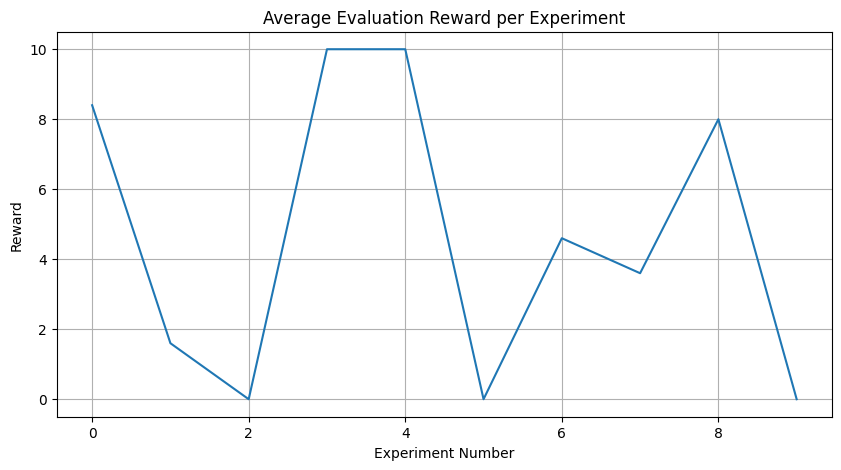

In [6]:
plt.figure(figsize=(10, 5))
plt.plot(df["avg_eval_reward"])
plt.title("Average Evaluation Reward per Experiment")
plt.xlabel("Experiment Number")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


In [10]:
import gymnasium as gym
from stable_baselines3 import DQN
from stable_baselines3.common.atari_wrappers import AtariWrapper
import ale_py
import time

def make_eval_env(render_mode="human"):
    base_env = gym.make("ALE/Bowling-v5", render_mode=render_mode)
    return AtariWrapper(base_env)

# Load the best model (exp 4)
best_model_path = "dqn_model_exp4.zip"
custom_overrides = {"buffer_size": 50_000}  # shrink replay buffer footprint when loading
model = DQN.load(best_model_path, custom_objects=custom_overrides, device="cpu")

# Create human render environment with the same preprocessing as training
env = make_eval_env(render_mode="human")

obs, info = env.reset()
done = False

print("Playing with best model:", best_model_path)

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    time.sleep(0.02)  # smooth rendering

env.close()

Playing with best model: dqn_model_exp4.zip


### Play instructions
To view the trained agent in action from the terminal:
1. Ensure Atari ROMs are installed (run `AutoROM --accept-license` once if you have not already).
2. From the parent folder of this notebook, execute `python play.py --model-path dqn_model_exp4.zip`.(4th experiment was the best followed by 5th)
3. Watch the SDL window that opens for real-time gameplay (use `--frame-delay` to tweak speed).
4. Optional flags: `--episodes N` to run multiple games, `--no-render` for headless evaluation.